# Repair GPX Files

In [1]:
import os, sys
import copy
import gpxpy
import gpxpy.gpx
import gpxpy.geo
import pandas as pd
import matplotlib.pyplot as plt

## Load File

In [2]:
FILE_PATH = "test_files/files/"
REFERENCE_PATH = "test_files/reference_files/"
RESULT_PATH = "test_files/result_files/"


FILE_NAME_1 = "29_04_2023.gpx"
FILE_NAME_2 = "30_04_2023.gpx"

with open(os.path.join(FILE_PATH, FILE_NAME_1), "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

## Parse File
Parse GPX file in order to retrieve lost data.

In [3]:
gpx.author_name

In [4]:
gpx.name

In [5]:
gpx.author_email

In [6]:
gpx.link

'http://www.garmin.com'

In [7]:
# Number of data points in GPX file
gpx.get_track_points_no()

1550

In [8]:
# Altitude range
gpx.get_elevation_extremes()

MinimumMaximum(minimum=478.87, maximum=1084.5)

In [9]:
# Elevation gain and loss
gpx.get_uphill_downhill()

UphillDownhill(uphill=1107.6390000000001, downhill=813.9490000000003)

In [10]:
# Time bounds
gpx.get_time_bounds()

TimeBounds(start_time=datetime.datetime(2023, 4, 29, 9, 49, 52, tzinfo=SimpleTZ("Z")), end_time=datetime.datetime(2023, 4, 29, 16, 36, 52, tzinfo=SimpleTZ("Z")))

In [11]:
# Duration (in seconds)
gpx.get_duration()

24420.0

In [12]:
# Moving time, stopped time, moving distance, stopped distance, max speed
gpx.get_moving_data()

MovingData(moving_time=18386.0, stopped_time=9743.0, moving_distance=22022.339946674754, stopped_distance=1020.3727948517267, max_speed=1.580216114689381)

## Visualise File

Text(0.5, 1.0, 'Track')

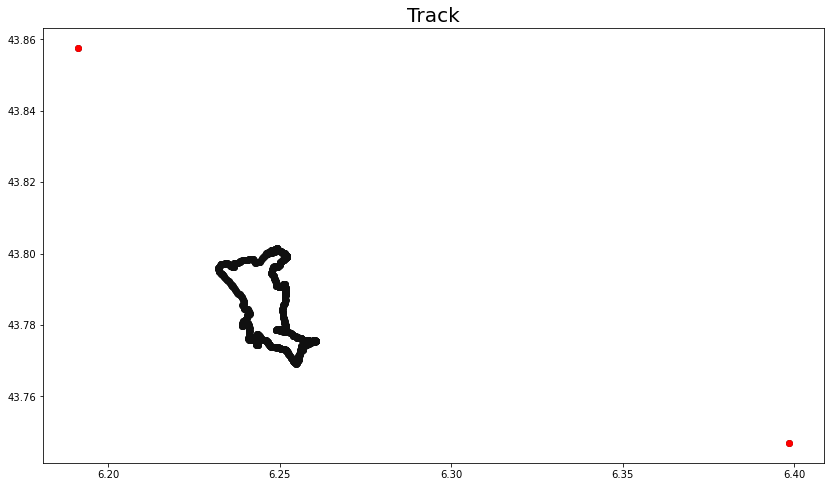

In [13]:
route_info = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                "latitude": point.latitude,
                "longitude": point.longitude,
                "elevation": point.elevation
            })

route_df = pd.DataFrame(route_info)

plt.figure(figsize=(14, 8))
plt.scatter(route_df["longitude"], route_df["latitude"], color="#101010")
plt.scatter(route_df["longitude"][len(route_df["longitude"])-1], route_df["latitude"][len(route_df["longitude"])-1], color="#FF0000")
plt.scatter(route_df["longitude"][len(route_df["longitude"])-2], route_df["latitude"][len(route_df["longitude"])-2], color="#FF0000")
plt.title("Track", size=20)

## Remove GPS Errors

In [14]:
# Create new "file"
cleaned = gpxpy.gpx.GPX()

previous_point = None
error_distance = 1000 # in meters

for track in gpx.tracks:
    # Create track
    gpx_track = gpxpy.gpx.GPXTrack()
    cleaned.tracks.append(gpx_track)
    for segment in track.segments:
        # Create segment
        gpx_segment = gpxpy.gpx.GPXTrackSegment()
        gpx_track.segments.append(gpx_segment)
        for point in segment.points:
            # Create points
            if previous_point is None or gpxpy.geo.haversine_distance(previous_point.latitude,
                                                                      previous_point.longitude,
                                                                      point.latitude,
                                                                      point.longitude) < error_distance:
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(point.latitude, point.longitude, elevation=point.elevation))
                previous_point = point

file = open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_cleaned.gpx"), "w")
file.write(cleaned.to_xml())
file.close()

Text(0.5, 1.0, 'Track')

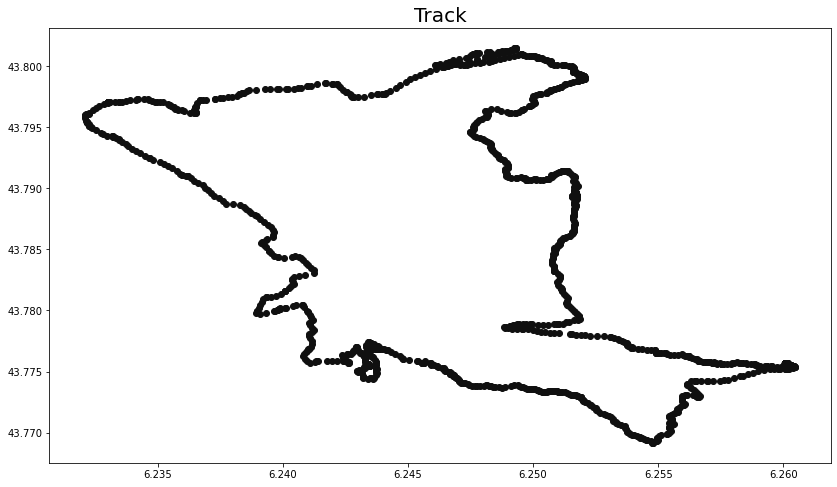

In [15]:
with open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_cleaned.gpx"), "r") as gpx_file:
    compressed_gpx = gpxpy.parse(gpx_file)

route_info = []

for track in compressed_gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                "latitude": point.latitude,
                "longitude": point.longitude,
                "elevation": point.elevation
            })

route_df = pd.DataFrame(route_info)

# Visualize compressed file
plt.figure(figsize=(14, 8))
plt.scatter(route_df["longitude"], route_df["latitude"], color="#101010")
plt.title("Track", size=20)

## "Compress" File

### Compress by Hand

In [16]:
# Create new "file"
compressed = gpxpy.gpx.GPX()

i = 0
compression_factor = 4

for track in gpx.tracks:
    # Create track
    gpx_track = gpxpy.gpx.GPXTrack()
    compressed.tracks.append(gpx_track)
    for segment in track.segments:
        # Create segment
        gpx_segment = gpxpy.gpx.GPXTrackSegment()
        gpx_track.segments.append(gpx_segment)
        for point in segment.points:
            # Create points
            i += 1
            if i % compression_factor == 0:
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(point.latitude, point.longitude, elevation=point.elevation))

file = open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_reduce.gpx"), "w")
file.write(compressed.to_xml())
file.close()

Text(0.5, 1.0, 'Track')

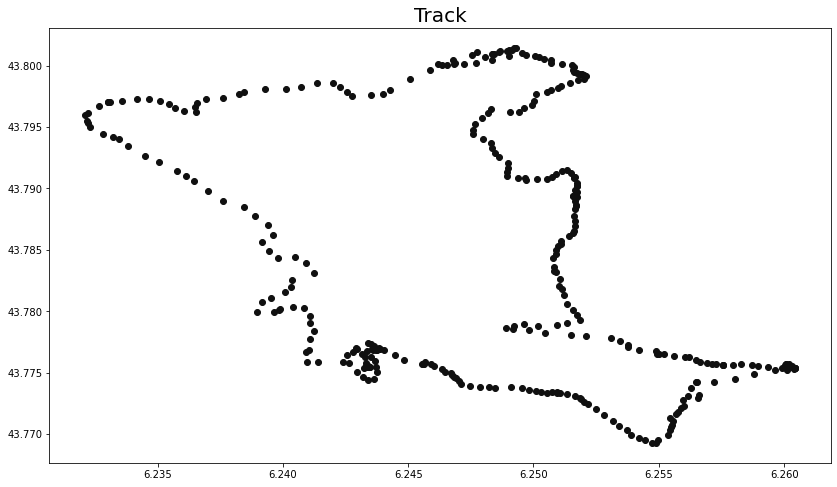

In [17]:
with open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_reduce.gpx"), "r") as gpx_file:
    compressed_gpx = gpxpy.parse(gpx_file)

route_info = []

for track in compressed_gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                "latitude": point.latitude,
                "longitude": point.longitude,
                "elevation": point.elevation
            })

route_df = pd.DataFrame(route_info)

# Visualize compressed file
plt.figure(figsize=(14, 8))
plt.scatter(route_df["longitude"], route_df["latitude"], color="#101010")
plt.title("Track", size=20)

### Compress using gpxpy

In [18]:
with open(os.path.join(FILE_PATH, FILE_NAME_1), "r") as gpx_file:
    compressed = gpxpy.parse(gpx_file)

compression_factor = 4

compressed.smooth(vertical=True, horizontal=True)
compressed.smooth(vertical=False, horizontal=True)
compressed.reduce_points(compressed.get_track_points_no()/compression_factor)

file = open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_gpxpy_reduce.gpx"), "w")
file.write(compressed.to_xml())
file.close()

Text(0.5, 1.0, 'Track')

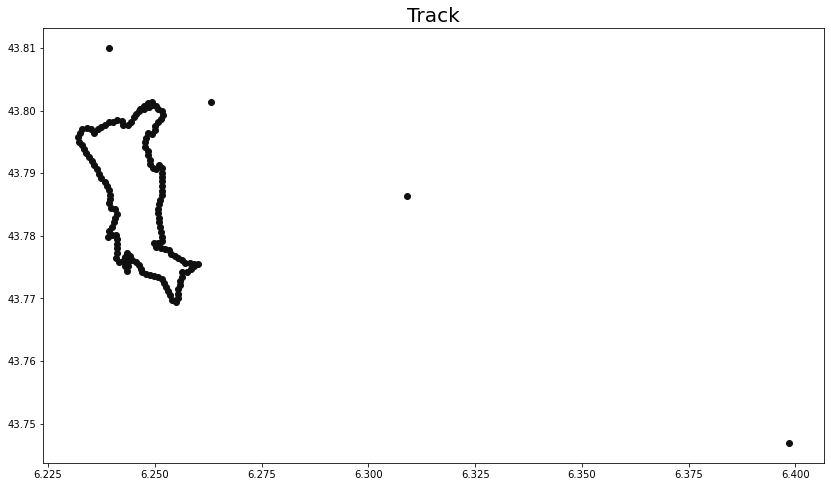

In [19]:
with open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_gpxpy_reduce.gpx"), "r") as gpx_file:
    compressed_gpx = gpxpy.parse(gpx_file)

route_info = []

for track in compressed_gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                "latitude": point.latitude,
                "longitude": point.longitude,
                "elevation": point.elevation
            })

route_df = pd.DataFrame(route_info)

# Visualize compressed file
plt.figure(figsize=(14, 8))
plt.scatter(route_df["longitude"], route_df["latitude"], color="#101010")
plt.title("Track", size=20)

### Simplify using gpxpy

In [20]:
with open(os.path.join(FILE_PATH, FILE_NAME_1), "r") as gpx_file:
    simplified = gpxpy.parse(gpx_file)

simplified.smooth(vertical=True, horizontal=True)
simplified.smooth(vertical=False, horizontal=True)
simplified.simplify()

file = open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_gpxpy_simplify.gpx"), "w")
file.write(simplified.to_xml())
file.close()

Text(0.5, 1.0, 'Track')

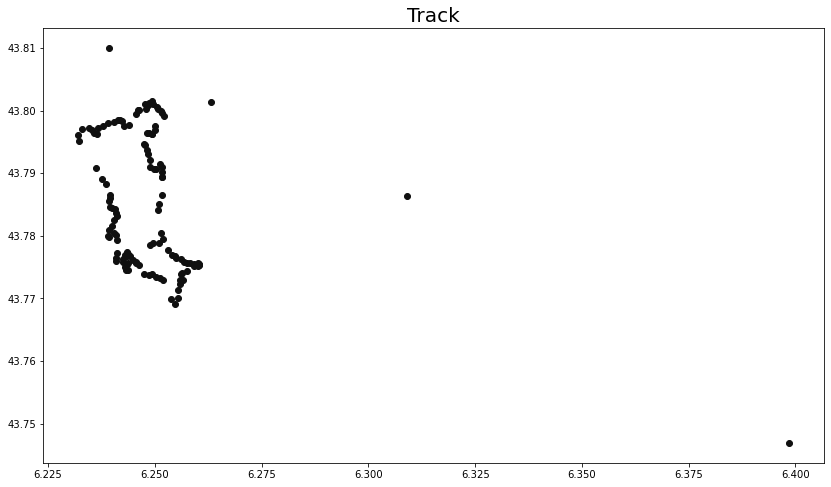

In [21]:
with open(os.path.join(RESULT_PATH, FILE_NAME_1[:-4] + "_gpxpy_simplify.gpx"), "r") as gpx_file:
    compressed_gpx = gpxpy.parse(gpx_file)

route_info = []

for track in compressed_gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                "latitude": point.latitude,
                "longitude": point.longitude,
                "elevation": point.elevation
            })

route_df = pd.DataFrame(route_info)

# Visualize compressed file
plt.figure(figsize=(14, 8))
plt.scatter(route_df["longitude"], route_df["latitude"], color="#101010")
plt.title("Track", size=20)

## Tests